In [28]:
#Data organization and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#ML
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

RS = 5 #RandomState variable setted here to reproduce same results

In [29]:
#Loading data
fileName = "diamonds.csv"
df = pd.read_csv(fileName)
df = df.drop("Unnamed: 0", axis=1)

#Check for missing values
print(df.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [30]:
#Visualize data
display(df)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


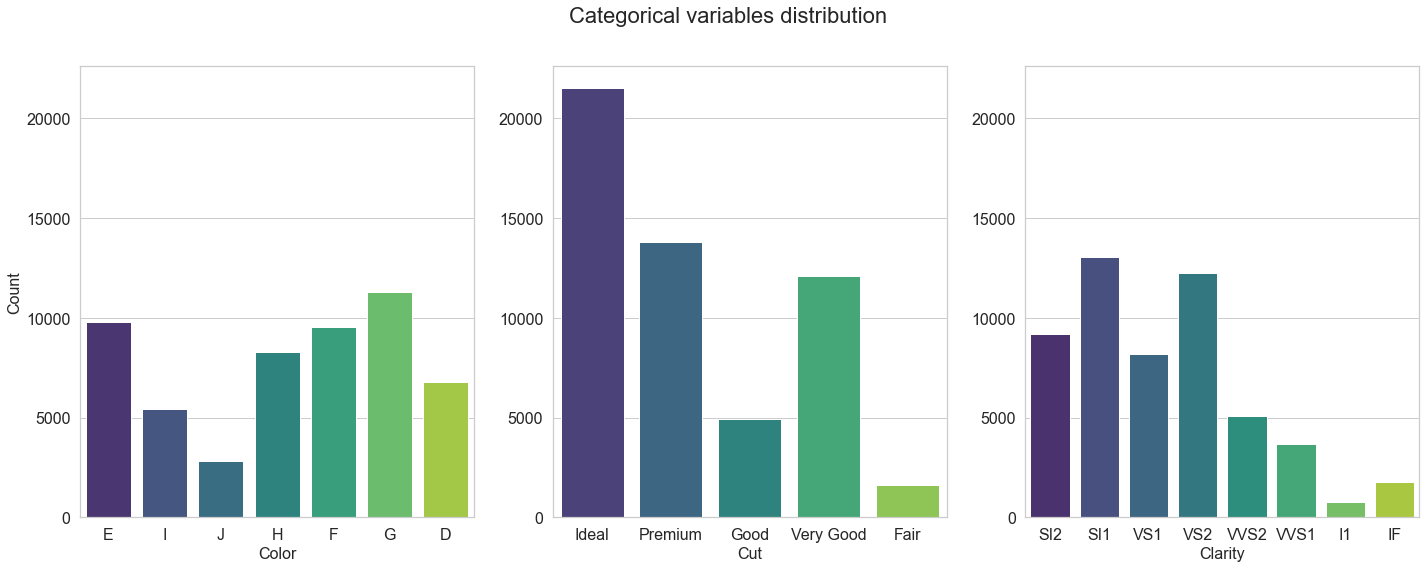

In [31]:
#Visualize categorical data distribution

fig = plt.figure(figsize=(24, 8.3))
fig.suptitle("Categorical variables distribution", fontsize=22)


ax1=plt.subplot(131)
g = sns.countplot(x='color', data=df, palette="viridis")
ax1.set_xlabel("Color",fontsize=16)
ax1.set_ylabel("Count", fontsize=16)

ax2=plt.subplot(132, sharey=ax1)
g2 = sns.countplot(x='cut', data=df, palette="viridis")
ax2.set_xlabel("Cut",fontsize=16)
ax2.get_yaxis().get_label().set_visible(False)

ax3=plt.subplot(133, sharey=ax1)
g3 = sns.countplot(x='clarity', data=df, palette="viridis")
ax3.set_xlabel("Clarity",fontsize=16)
ax3.get_yaxis().get_label().set_visible(False)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(labelsize=16)


    




In [32]:
#Preprocessing
#Replacing String values with numbers

#Increasing order for Cut
#Fair, Good, Very Good, Premium, Ideal
cuts = {'Fair'      : 1, 
        'Good'      : 2, 
        'Very Good' : 3, 
        'Premium'   : 4,
        'Ideal'     : 5}
for c in cuts.keys():
    df['cut'] = df['cut'].replace(c, cuts[c])

    
#Increasing order for Clarity
#I1 , SI2, SI1, VS2, VS1, VVS2, VVS1, IF
clarity = {'I1'   : 1,
           'SI2'  : 2,
           'SI1'  : 3,
           'VS2'  : 4,
           'VS1'  : 5,
           'VVS2' : 6,
           'VVS1' : 7,
           'IF'   : 8}

for c in clarity.keys():
    df['clarity'] = df['clarity'].replace(c, clarity[c])
    
    
#Increasing order for color
col = df['color'].unique()
col.sort()

#Replacing with numbers
i = 1
for c in col:
    df['color'] = df['color'].replace(c, i)
    i +=1


Text(0.5, 1.0, 'Price Distribution')

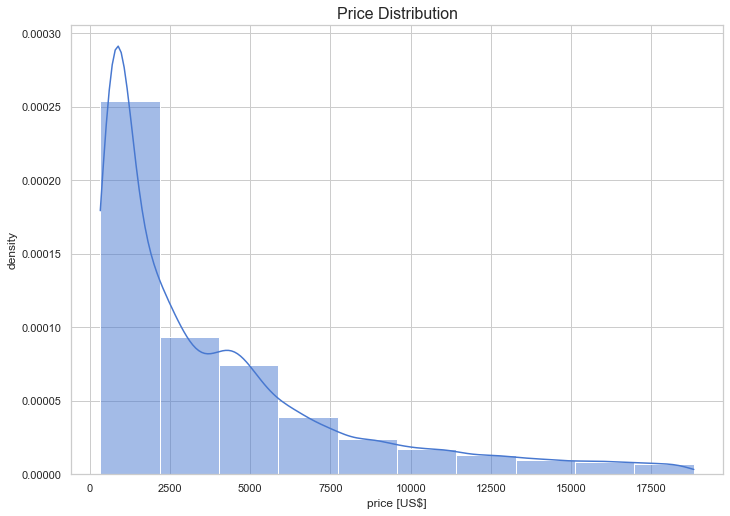

In [33]:
#Price distributions among the dataset
sns.set(style = 'whitegrid', rc={'figure.figsize':(11.7,8.27)}, palette='muted')
ax = sns.histplot(df['price'], bins=10, kde=True, stat='density')
ax.set_ylabel("density")
ax.set_xlabel("price [US$]")
ax.set_title("Price Distribution", fontsize=16)

<AxesSubplot:>

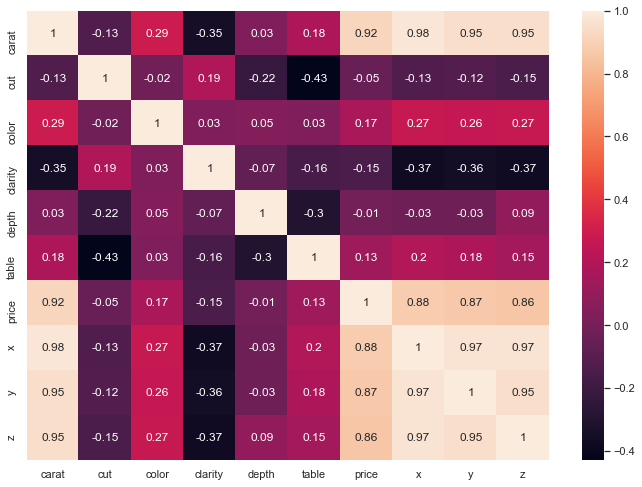

In [34]:
#Studying correlation matrix
cMat = df.corr().round(2)
sns.heatmap(data=cMat, annot=True)

From the correlation matrix we see price is poorly correlated with cut and depth, so we may drop this 2 values (?)

We also see that for pricing the diamonds carat, x, y, and z bring almost the same information. We may want to use only one of this predictors (?)

### Linear Regression
We begin by studying a linear regression model using all predictors. Since targets are not Normally distributed linear regression fails in its assumption. Therefore it can be convenient to study a transformed target such as $log(y)$, which at least makes the targets distributed more simmetrically.  
We also introduce Ridge regularization because there are some strong correlated variables, that may leed to problem in inversion of matrix $X^TX$

Text(0.5, 1.0, 'log(Price) Distribution')

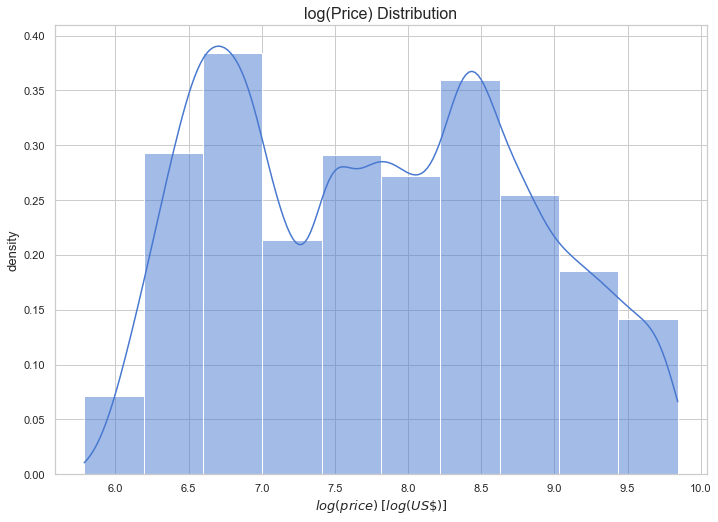

In [35]:
#New price distributions among the dataset
sns.set(style = 'whitegrid', rc={'figure.figsize':(11.7,8.27)}, palette='muted')
ax = sns.histplot(np.log(df['price']), bins=10, kde=True, stat='density')
ax.set_ylabel("density", fontsize=13)
ax.set_xlabel(f"$log(price)$ $[log(US\$)]$", fontsize=13)
ax.set_title("log(Price) Distribution", fontsize=16)

In [36]:
#First we select predictors and targets, transforming the last
#And divide train and test data


X_rid = df[['carat', 'cut', 'color', 'clarity', 'depth',
        'table','x', 'y', 'z']]
Y_rid = np.log(df['price'])

X_rid_train, X_rid_test, Y_rid_train, Y_rid_test = train_test_split(X_rid, Y_rid, test_size = 0.2, random_state=RS)
print(X_rid_train.shape)
print(X_rid_test.shape)
print(Y_rid_train.shape)
print(Y_rid_test.shape)

(43152, 9)
(10788, 9)
(43152,)
(10788,)


In [37]:
from sklearn.linear_model import Ridge

r = Ridge()
r.fit(X_rid_train, Y_rid_train)

# model evaluation for training set

y_rid_train_p = r.predict(X_rid_train)
rmse = (np.sqrt(mean_squared_error(Y_rid_train, y_rid_train_p)))
r2 = r2_score(Y_rid_train, y_rid_train_p)

print("Ridge performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_rid_test_p = r.predict(X_rid_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_rid_test, y_rid_test_p)))

# r-squared score of the model
r2 = r2_score(Y_rid_test, y_rid_test_p)

print("Ridge performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

Ridge performance for training set
--------------------------------------
RMSE is 0.18986379897849032
R2 score is 0.9651368156863233


Ridge performance for testing set
--------------------------------------
RMSE is 0.17767811243153137
R2 score is 0.9687872718265651


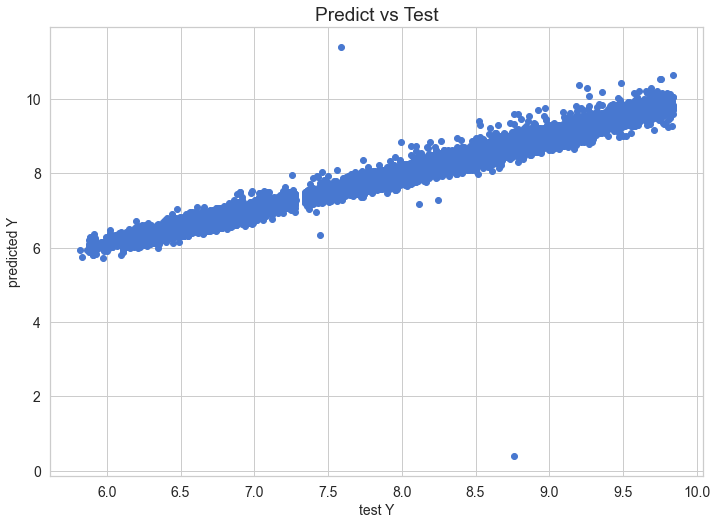

In [38]:
# plotting the y_test vs y_pred
# we want it to be the 1st quadrant bisector
fs = 14
plt.scatter(Y_rid_test, y_rid_test_p)
plt.xlabel("test Y", fontsize=fs)
plt.ylabel("predicted Y", fontsize=fs)
plt.title("Predict vs Test", fontsize=19)
plt.tick_params(labelsize=fs)
plt.show()

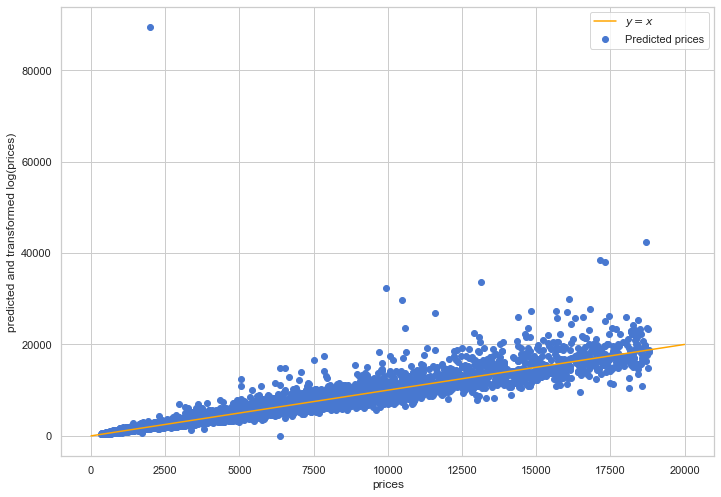

In [46]:
# plotting the transformed predicted Y back to price, and 
# comparing them with original data

prices = df['price']
_, _, _, real_Y = train_test_split(X_rid, prices, test_size = 0.2, random_state=RS)
plt.scatter(real_Y, np.exp(y_rid_test_p), label='Predicted prices')
plt.plot(np.arange(0, 20000), np.arange(0, 20000), color='orange', label=r'$y= x$')
plt.xlabel("prices")
plt.ylabel("predicted and transformed log(prices)")
plt.legend()
plt.show()

We can see that prediction are enough close to real values, except for few outliers. We also notice that with the increasing in price there is a kind of widening along the quadrant bisector. This is probably due to the logarithmic transformation that has been applied to targets, in fact errors in the prediction when transformed back results in being exponentially increased and multiplied to the real values, therefore the bigger the value, the bigger the error. To clarify this we present the following explanation:
From linear regression we obtain 
$$
\hat{y}_1 = f(\mathbf{x_1}) + \epsilon 
$$
But this is the $log$ of the price, so we transform it back, obtaining:
$$
\hat{p}_1 = e^{y_1} = e^\epsilon e^{ f(\mathbf{x_1})}
$$
Given the real price $p_1$, the distance from the prediction is:
$$
p_1-\hat{p}_1 =  e^{ f(\mathbf{x_1})}(1 - e^\epsilon)
$$
Which clearly increases when $f(\mathbf{x_1})$ does so.  
We like to underline the fact that here epsilon is not strictly $>0$ so the error can be either over/under estimation, but when it is $\epsilon>0$ then the error exponentially grows as we can see in the outlier above 80k of predicted price

### Linear Regression 2

We then try to improve the prediction by choosing only one of the strong correlated variables ($x, y, z, carat$) and dropping the others. We choose $carat$ because is the one with higher correlation with the target.

In [58]:
#We drop the correlated predictors and rebuild train and model data

X_lr = {}
X_lr_train = {}
X_lr_test = {}
Y = np.log(df['price'])
for f in ['x', 'y', 'z', 'carat']:
    #Add only one of this 4 features in each set
    X_lr[f] =  df[['cut', 'color', 'clarity', 'depth',
                'table',f]]
    X_lr_train[f], X_lr_test[f], Y_train, Y_test = train_test_split(X_lr[f], Y, test_size = 0.2, random_state=5)
    



print(X_lr_train['x'].shape)
print(X_lr_test['x'].shape)
print(Y_train.shape)
print(Y_test.shape)

(43152, 6)
(10788, 6)
(43152,)
(10788,)


In [68]:
lr = {}
for f in ['x', 'y', 'z', 'carat']:
    lr[f] = LinearRegression().fit(X_lr_train[f], Y_train)

# model evaluation for training set
    y_train_predict = lr[f].predict(X_lr_train[f])
    rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
    r2 = r2_score(Y_train, y_train_predict)

    
    print("Results using only feature {}\n".format(f))
    print("The Linear Regression performance for training set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

    # model evaluation for testing set

    y_test_predict = lr[f].predict(X_lr_test[f])
    # root mean square error of the model
    rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))

    # r-squared score of the model
    r2 = r2_score(Y_test, y_test_predict)

    print("The Linear Regression for testing set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

Results using only feature x

The Linear Regression performance for training set
--------------------------------------
RMSE is 0.20139691686819425
R2 score is 0.9607727056168085


The Linear Regression for testing set
--------------------------------------
RMSE is 0.1921540205401834
R2 score is 0.9634941203035163


Results using only feature y

The Linear Regression performance for training set
--------------------------------------
RMSE is 0.32581892713190375
R2 score is 0.8973319442682784


The Linear Regression for testing set
--------------------------------------
RMSE is 0.20497390176366265
R2 score is 0.958460525047611


Results using only feature z

The Linear Regression performance for training set
--------------------------------------
RMSE is 0.23536250536876288
R2 score is 0.9464256049462538


The Linear Regression for testing set
--------------------------------------
RMSE is 0.4681126873457234
R2 score is 0.7833470082144649


Results using only feature carat

The Linear R

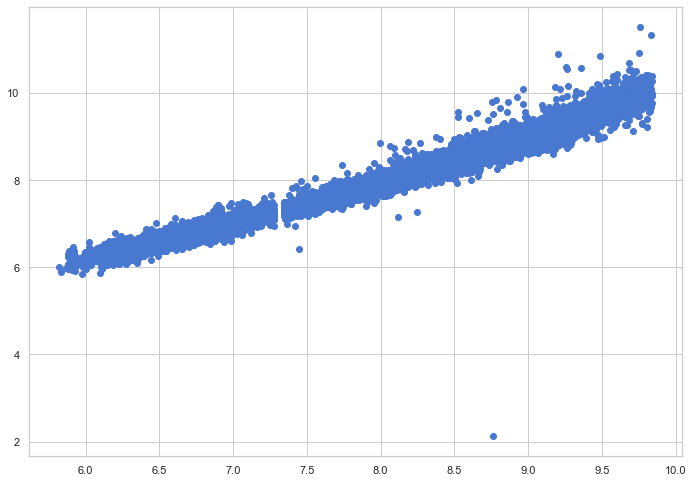

In [61]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.scatter(Y_test, y_test_predict)
plt.show()

Both from scatterplot and accuracy values we see that decreasing the model complexity actually doesn't improve the prediction nor the variance, instead they worsen a little. Maybe the problem is the variable we have chosen between the 4 strongly correlated. Actually by dropping $x, y, z$ we have lost almost all the information about the spatial dimension of the diamond, which surely is important in defining the price (seeing it in the simplest way: _the bigger the diamond, the higher the price_)

### Random Forest

With random forest we have no need to transform the target variable, since there's no request of it being well distributed. Therefore we use raw data.

In [16]:
X_rf = df.drop('price', axis=1)
Y_rf = df['price']

X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(X_rf, Y_rf, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(43152, 6)
(10788, 6)
(43152,)
(10788,)


In [18]:
from sklearn.ensemble import RandomForestRegressor
##
##
## CONSIDER USING MIN_SAMPLE_LEAF FOR SMOOTHING THE REGRESSION
##
##
rf = RandomForestRegressor(max_depth=30, random_state=0)
rf.fit(X_train, Y_train)


# model evaluation for training set

y_train_predict = rf.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_test_predict = rf.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.0520458181589387
R2 score is 0.997380282874485


The model performance for testing set
--------------------------------------
RMSE is 0.10986538399650017
R2 score is 0.9880660112944162


### Price per carat

In [78]:
df['ppc'] = df['price']/df['carat']


In [79]:
display(df)

,carat,cut,color,clarity,depth,table,price,x,y,z,ppc
0,0.23,5,2,2,61.5,55.0,326,3.95,3.98,2.43,1417.391304
1,0.21,4,2,3,59.8,61.0,326,3.89,3.84,2.31,1552.380952
2,0.23,2,2,5,56.9,65.0,327,4.05,4.07,2.31,1421.739130
3,0.29,4,6,4,62.4,58.0,334,4.20,4.23,2.63,1151.724138
4,0.31,2,7,2,63.3,58.0,335,4.34,4.35,2.75,1080.645161
...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,5,1,3,60.8,57.0,2757,5.75,5.76,3.50,3829.166667
53936,0.72,2,1,3,63.1,55.0,2757,5.69,5.75,3.61,3829.166667
53937,0.70,3,1,3,62.8,60.0,2757,5.66,5.68,3.56,3938.571429
53938,0.86,4,5,2,61.0,58.0,2757,6.15,6.12,3.74,3205.813953


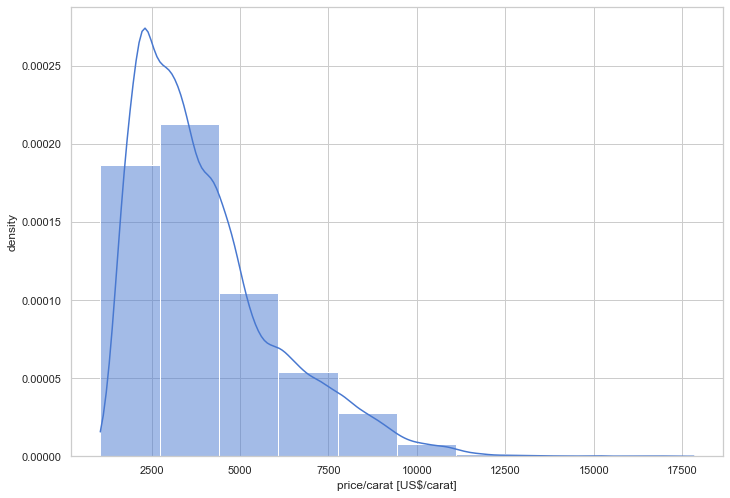

<AxesSubplot:>

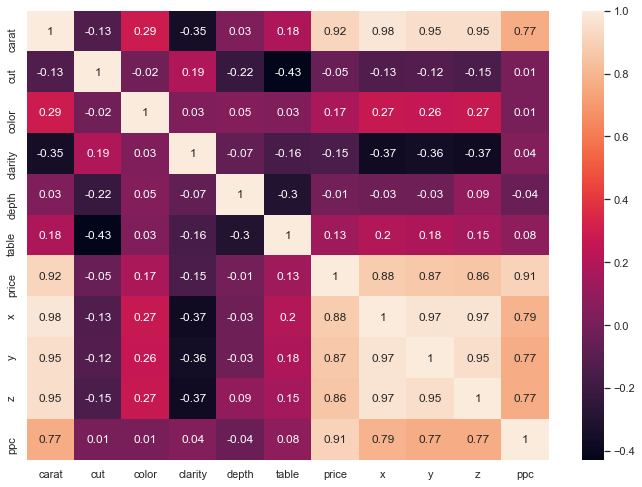

In [82]:
#Trying regression for price per carat
#Correlation matrix with it first, and distribution of target
sns.set(style = 'whitegrid', rc={'figure.figsize':(11.7,8.27)}, palette='muted')
ax = sns.histplot(df['ppc'], bins=10, kde=True, stat='density')
ax.set_ylabel("density")
ax.set_xlabel("price/carat [US$/carat]")
plt.show()
#Studying correlation matrix
cMat = df.corr().round(2)
sns.heatmap(data=cMat, annot=True)

In [ ]:
#First we select predictors and targets, transforming the last
#And divide train and test data


X = df[['carat', 'cut', 'color', 'clarity', 'depth',
        'table','x', 'y', 'z']]
Y = np.log(df['price'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=3)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)